In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 전력사용량(kWh) 예측
# 1. 데이터 불러오기
# 2. 데이터 전처리
# 3. 모델링
# 4. 모델 평가
# 5. 모델 예측
# 6. 제출 파일 생성
# 7. 제출 및 결과 확인

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import os
from os.path import join
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
data_dir = '/content/drive/MyDrive/아이펠 데이터/datathon'

In [ ]:
train_path = join(data_dir, 'train.csv')
print(train_path)
train = pd.read_csv(train_path, encoding='euc-kr')
train.head()

/content/drive/MyDrive/아이펠 데이터/datathon/train.csv


,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [ ]:
test_path = join(data_dir, 'test.csv')
print(test_path)
test = pd.read_csv(test_path, encoding='euc-kr')
test.head()

/content/drive/MyDrive/아이펠 데이터/datathon/test.csv


,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sub_path = join(data_dir, 'sample_submission.csv')
print(sub_path)
sub = pd.read_csv(sub_path, encoding='euc-kr')
sub.head()

/content/drive/MyDrive/아이펠 데이터/datathon/sample_submission.csv


,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0


In [ ]:
# 데이터 전처리
# 1. 데이터 탐색

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   num         122400 non-null  int64  
 1   date_time   122400 non-null  object 
 2   전력사용량(kWh)  122400 non-null  float64
 3   기온(°C)      122400 non-null  float64
 4   풍속(m/s)     122400 non-null  float64
 5   습도(%)       122400 non-null  float64
 6   강수량(mm)     122400 non-null  float64
 7   일조(hr)      122400 non-null  float64
 8   비전기냉방설비운영   122400 non-null  float64
 9   태양광보유       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [ ]:
# 2. 결측치 확인

train.isnull().sum()


num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

위의 결과를 통해 train에는 결측치가 없음을 확인

In [ ]:
test.isnull().sum()


num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

그러나 test에는 결측치가 특정한 주기로 존재한다.

In [ ]:
# 테스트 결측치 보간

train[['num', '비전기냉방설비운영','태양광보유']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'비전기냉방설비운영']
    hot[count]=train.loc[i,'태양광보유']

for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영']=ice[test['num'][i]]
    test.loc[i, '태양광보유']=hot[test['num'][i]]

test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,0.0,0.0
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,0.0,0.0


'비전기냉방설비운영', '태양광보유'는 건물에 고정된 형태이므로 train set에서 가져온다.

In [ ]:
test.interpolate(method='values', inplace=True)
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.0,0.0,0.0
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.0,0.0,0.0
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.0,0.0,0.0


일기예보 형태로 되어있는 나머지 결측치는 선형으로 보간한다.

이제 date_time을 학습에 용이한 형태로 바꿔주자.

In [ ]:
# 3. 데이터 타입 변환

def time(x):
    x['date'] = pd.to_datetime(x['date_time'])
    x['year'] = x['date'].dt.year
    x['month'] = x['date'].dt.month
    x['day'] = x['date'].dt.day
    x['hour'] = x['date'].dt.hour

time(train)
time(test)

def weekday(x):
    return pd.to_datetime(x[:10]).weekday()

train['weekday']=train['date_time'].apply(lambda x :weekday(x))
test['weekday']=test['date_time'].apply(lambda x :weekday(x))

train.head()


,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date,year,month,day,hour,weekday
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,2020-06-01 00:00:00,2020,6,1,0,0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,2020-06-01 01:00:00,2020,6,1,1,0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01 02:00:00,2020,6,1,2,0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,2020-06-01 03:00:00,2020,6,1,3,0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,2020-06-01 04:00:00,2020,6,1,4,0


In [ ]:
# 4. 이상치 확인

train.describe()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,year,month,day,hour,weekday
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.0,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333,2020.0,6.929412,14.835294,11.500000,2.964706
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724,0.0,0.793925,8.446192,6.922215,2.014351
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,2020.0,6.000000,1.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000,2020.0,6.000000,8.000000,5.750000,1.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000,2020.0,7.000000,15.000000,11.500000,3.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000,2020.0,8.000000,22.000000,17.250000,5.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000,2020.0,8.000000,31.000000,23.000000,6.000000


In [ ]:
Not2020 = train[train['year'] != 2020] # 모든 year가 2020 이다.
Not2020.head() 

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,date,year,month,day,hour,weekday


In [ ]:
y = train['전력사용량(kWh)']

features = ['num','기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유', 'month', 'day', 'hour','weekday']
X = train[features]
X.head()

,num,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekday
0,1,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0
1,1,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0
2,1,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0
3,1,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0
4,1,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0


In [ ]:
# 모델 탐색
# 1. 데이터 분할
from sklearn.model_selection import train_test_split

random_state = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# 2. 모델 생성
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=0 # 랜덤스테이트 설정
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

# 3. 모델 평가 
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)


[14:39:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,858.723508
GradientBoostingRegressor,830.957465
LGBMRegressor,317.810765
RandomForestRegressor,150.987097


In [ ]:
# 모델링 (RandomForestRegression)
# 1. 데이터 분할

from sklearn.model_selection import train_test_split

random_state = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# 2. 모델 생성

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=300, random_state=random_state)

# 3. 모델 학습

model.fit(X_train, y_train)

# 4. 모델 예측

y_pred = model.predict(X_test)

RMSE =  150.07933155822982
R2 Score =  0.9946567605277995


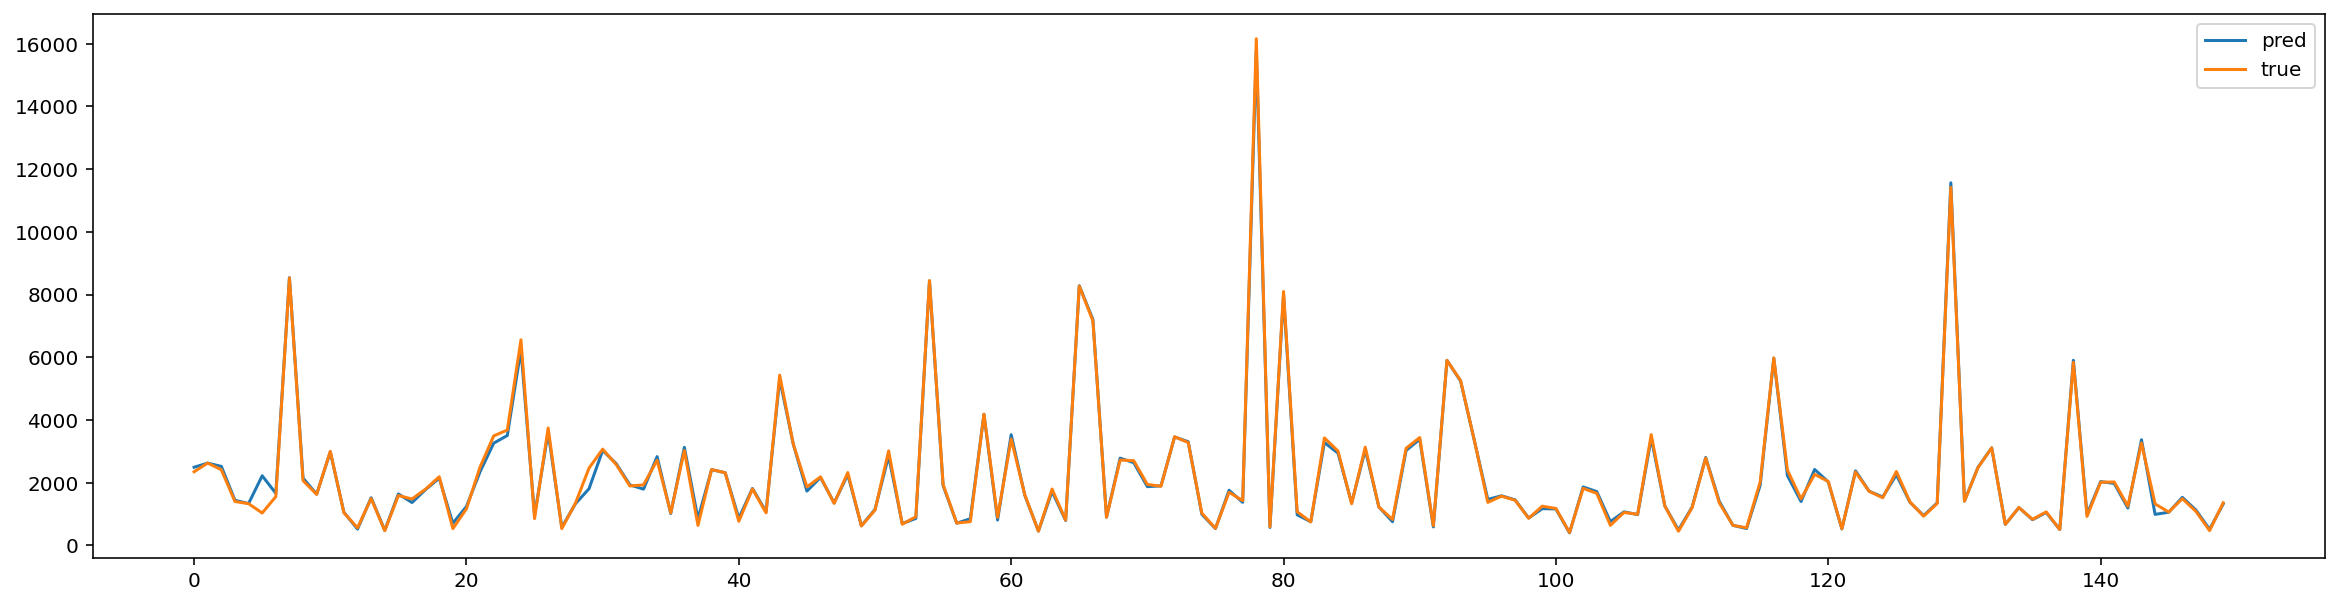

In [ ]:
# 모델 평가
from sklearn.metrics import r2_score
print('RMSE = ', rmse(y_test, y_pred))
print('R2 Score = ', r2_score(y_test, y_pred))

def corange(a,b): # 특정 구간에서 비교하는 함수
    plt.figure(figsize=(20, 5))
    # sns.lineplot(data=train[train['num']==1], x='date_time', y='전력사용량(kWh)', label='num=1')
    # 위는 한 건물의 전체 데이터 그래프를 그리는 코드
    sns.lineplot(data=y_pred[a:b], label='pred')
    sns.lineplot(data=y_test.values[a:b], label='true')
    plt.show()

corange(200,350)

n_estimators=300 일 때, RMSE = 150.07, R2 Score = 0.995

In [ ]:
# 모델 예측
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,date,year,month,day,hour,weekday
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,2020-08-25 00:00:00,2020,8,25,0,1
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.0,0.0,0.0,2020-08-25 01:00:00,2020,8,25,1,1
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.0,0.0,0.0,2020-08-25 02:00:00,2020,8,25,2,1
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0,2020-08-25 03:00:00,2020,8,25,3,1
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.0,0.0,0.0,2020-08-25 04:00:00,2020,8,25,4,1


In [ ]:
test = test.rename(columns={'강수량(mm, 6시간)':'강수량(mm)', '일조(hr, 3시간)':'일조(hr)'})
test = test[features]
test.head()

,num,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekday
0,1,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,8,25,0,1
1,1,27.633333,1.366667,75.333333,0.0,0.0,0.0,0.0,8,25,1,1
2,1,27.466667,1.233333,76.666667,0.0,0.0,0.0,0.0,8,25,2,1
3,1,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0,8,25,3,1
4,1,26.900000,1.166667,79.666667,0.0,0.0,0.0,0.0,8,25,4,1


In [ ]:
predictions = model.predict(test)
predictions

array([8667.702  , 8665.25904, 8664.29784, ..., 3607.38144, 3461.41296,
       3250.29744])

In [ ]:
sub.head()

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0


In [ ]:
# 제출파일 생성

def save(model_name, rmse):
  submission = pd.read_csv(sub_path)
  submission['answer'] = predictions
  submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, model_name, rmse)
  submission.to_csv(submission_csv_path, index=False)
  print('{} saved!'.format(submission_csv_path))

In [ ]:
save('RFR', 150.07)

/content/drive/MyDrive/아이펠 데이터/datathon/submission_RFR_RMSE_150.07.csv saved!


# 제출 및 결과 확인

RandomForestRegression, n_estimators = 300, RMSE = 150.07, R2 Score = 0.995  
점수: 6.38 